<a href="https://colab.research.google.com/github/FatmaBuseBorlu/YuzGoruntulerindenDuyguTanimaveTepkiVerme/blob/main/Yapay_Zeka_Projesi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [87]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [88]:
from google.colab import files
import zipfile
import os

# Yerel bilgisayardan dosya yükleme
uploaded = files.upload()

# Yüklenen dosyayı kontrol etme
for file_name in uploaded.keys():
    print(f"Yüklendi: {file_name}")

    # Eğer dosya bir ZIP ise, çıkar
    if file_name.endswith(".zip"):
        with zipfile.ZipFile(file_name, 'r') as zip_ref:
            zip_ref.extractall()  # Varsayılan dizine çıkarır
            print(f"{file_name} başarıyla çıkarıldı.")

Saving RAF-DB-DATASET.zip to RAF-DB-DATASET (1).zip
Yüklendi: RAF-DB-DATASET (1).zip
RAF-DB-DATASET (1).zip başarıyla çıkarıldı.


In [89]:
# Çalışma dizinindeki dosyaları listeleme
print(os.listdir())

# Çıkarılan veri seti klasörünün içeriğini listeleme
print(os.listdir("RAF-DB-DATASET/DATASET/test"))

['.config', '.ipynb_checkpoints', 'RAF-DB-DATASET', 'emotion_recognition_mobilenetv2_smote.h5', 'emotion_recognition_mobilenetv2.h5', 'RAF-DB-DATASET.zip', 'RAF-DB-DATASET (1).zip', 'sample_data']
['3', '4', '1', '6', '2', '7', '5']


In [90]:
# Eğitim ve test veri yolları
train_dir = "/content/RAF-DB-DATASET/DATASET/test"
test_dir = "/content/RAF-DB-DATASET/DATASET/test"

In [91]:
# Veri yükleme fonksiyonu
def load_data(directory):
    X, y = [], []
    for label in os.listdir(directory):
        label_path = os.path.join(directory, label)
        if os.path.isdir(label_path):
            for image_name in os.listdir(label_path):
                image_path = os.path.join(label_path, image_name)
                img = load_img(image_path, target_size=(224, 224))
                img_array = img_to_array(img)
                img_array = preprocess_input(img_array)  # MobileNetV2 için ön işleme
                X.append(img_array)
                y.append(int(label))
    return np.array(X), np.array(y)

# Eğitim ve test verilerini yükleme
X_train, y_train = load_data(train_dir)
X_test, y_test = load_data(test_dir)

In [92]:
# Etiketleri 0'dan başlatma
y_train -= 1
y_test -= 1

# Sınıf sayısını belirleme
num_classes = len(np.unique(y_train))

# Etiketleri kategorik hale getirme
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

print(f"Eğitim verileri: {X_train.shape}, Etiketler: {y_train.shape}")
print(f"Test verileri: {X_test.shape}, Etiketler: {y_test.shape}")

Eğitim verileri: (3068, 224, 224, 3), Etiketler: (3068, 7)
Test verileri: (3068, 224, 224, 3), Etiketler: (3068, 7)


In [93]:
# Veri artırma
data_augmentation = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

In [94]:
# MobileNetV2 tabanlı model oluşturma
base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base_model.trainable = True
for layer in base_model.layers[:100]:
    layer.trainable = False

# Modelin son katmanlarını ekleme
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),  # Daha büyük bir katman
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Modeli derleme
from tensorflow.keras.optimizers import SGD

from tensorflow.keras.optimizers import SGD

model.compile(optimizer=SGD(learning_rate=0.001, momentum=0.9),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [95]:
# Sınıf ağırlıklarını hesaplama
y_train_labels = np.argmax(y_train, axis=1)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_labels),
    y=y_train_labels
)
class_weights = dict(enumerate(class_weights))

print("Sınıf Ağırlıkları:", class_weights)

Sınıf Ağırlıkları: {0: 1.3321754233608336, 1: 5.922779922779923, 2: 2.7392857142857143, 3: 0.3698613622664256, 4: 0.9169157202630006, 5: 2.7054673721340388, 6: 0.6445378151260505}


In [96]:
# Callback'leri tanımlayın
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau # Import ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_loss',
                               patience=5,
                               restore_best_weights=True)

lr_reduction = ReduceLROnPlateau(monitor='val_loss',
                                 patience=3,
                                 verbose=1,
                                 factor=0.5,
                                 min_lr=1e-6)

In [97]:
# Modeli eğitme
history = model.fit(
    data_augmentation.flow(X_train, y_train, batch_size=32),
    epochs=30,  # Daha uzun eğitim
    validation_data=(X_test, y_test),
    class_weight=class_weights,
    callbacks=[lr_reduction, early_stopping]
)
# Eğitilen modeli kaydetme
model.save("emotion_recognition_mobilenetv2.h5")

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


96/96 ━━━━━━━━━━━━━━━━━━━━ 58s 429ms/step - accuracy: 0.1251 - loss: 2.2750 - val_accuracy: 0.2275 - val_loss: 1.8276 - learning_rate: 0.0010
Epoch 2/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 31s 301ms/step - accuracy: 0.2291 - loss: 1.8255 - val_accuracy: 0.2357 - val_loss: 1.7969 - learning_rate: 0.0010
Epoch 3/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 31s 300ms/step - accuracy: 0.2353 - loss: 1.6925 - val_accuracy: 0.2396 - val_loss: 1.7758 - learning_rate: 0.0010
Epoch 4/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 31s 300ms/step - accuracy: 0.3263 - loss: 1.5829 - val_accuracy: 0.3566 - val_loss: 1.6196 - learning_rate: 0.0010
Epoch 5/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 31s 301ms/step - accuracy: 0.3910 - loss: 1.5695 - val_accuracy: 0.4638 - val_loss: 1.4894 - learning_rate: 0.0010
Epoch 6/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 31s 301ms/step - accuracy: 0.4521 - loss: 1.4060 - val_accuracy: 0.5176 - val_loss: 1.3356 - learning_rate: 0.0010
Epoch 7/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 31s 301ms/step - accuracy: 0.4889 - loss: 1.3341 - val_

In [98]:
# Modeli test etme
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Doğruluğu: {test_accuracy * 100:.2f}%")

96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9073 - loss: 0.2812
Test Doğruluğu: 84.62%


In [99]:
# Modelin tahminlerini değerlendirme
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step


In [100]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_5           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 512)                 │         655,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 7)                   │           1,799 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,697,424 (21.73 MB)

 Trainable params: 2,650,439 (10.11 MB)

 Non-trainable params: 396,544 (1.51 MB)

 Optimizer params: 2,650,441 (10.11 MB)

In [101]:
# Hata Matrisi ve Sınıflandırma Raporu
cm = confusion_matrix(y_true_classes, y_pred_classes)
print("Confusion Matrix:\n", cm)
print("Classification Report:\n", classification_report(y_true_classes, y_pred_classes))

Confusion Matrix:
 [[ 302    1    8    6    3    1    8]
 [   0   74    0    0    0    0    0]
 [   0    0  160    0    0    0    0]
 [   9    1   58 1075   15    3   24]
 [   2    1   46   16  397    1   15]
 [   0    0    8    2    0  152    0]
 [   9    0  157   45   33    0  436]]
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.92      0.93       329
           1       0.96      1.00      0.98        74
           2       0.37      1.00      0.54       160
           3       0.94      0.91      0.92      1185
           4       0.89      0.83      0.86       478
           5       0.97      0.94      0.95       162
           6       0.90      0.64      0.75       680

    accuracy                           0.85      3068
   macro avg       0.85      0.89      0.85      3068
weighted avg       0.90      0.85      0.86      3068



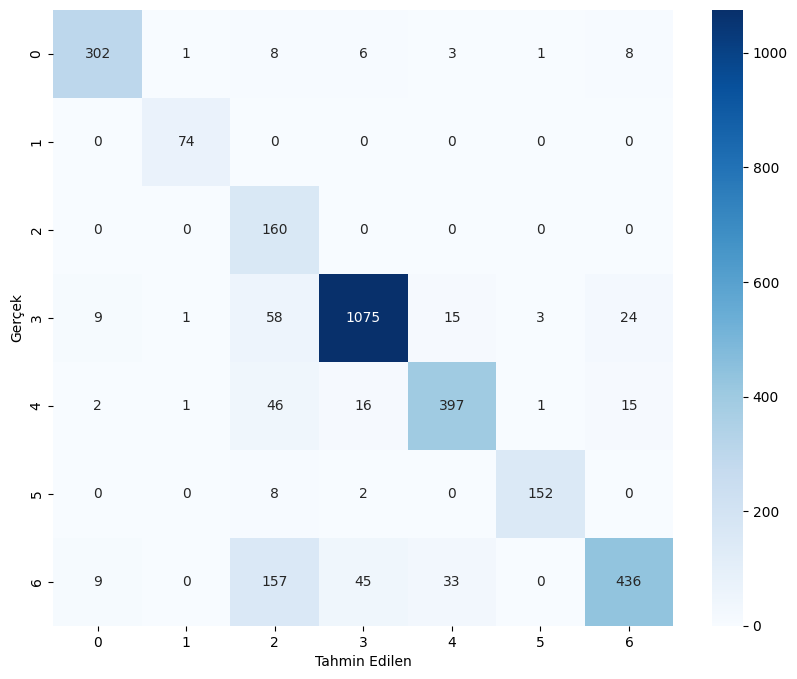

In [102]:
# Confusion matrix görselleştirme
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.xlabel("Tahmin Edilen")
plt.ylabel("Gerçek")
plt.show()

Test edilecek görüntü: /content/RAF-DB-DATASET/DATASET/test/1/test_1244_aligned.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


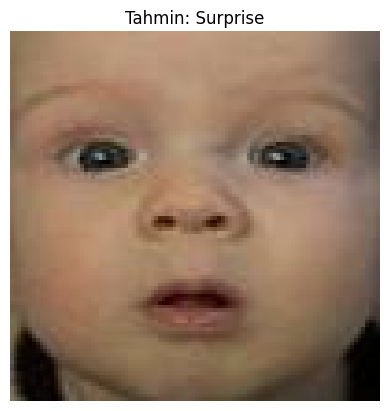

Modelin tahmini: Surprise


In [103]:
# Modeli yükleme
model = load_model("emotion_recognition_mobilenetv2.h5") # Change the filename to the correct one

# Test CSV dosyasını yükleme
test_csv_path = "/content/RAF-DB-DATASET/test_labels.csv"
test_data = pd.read_csv(test_csv_path)

# Rastgele bir görüntü seçme
random_row = test_data.sample(n=1).iloc[0]
test_image_name = random_row['image']
correct_label = random_row['label']

# Görüntü yolunu oluşturma
test_image_path = os.path.join("/content/RAF-DB-DATASET/DATASET/test", str(correct_label), test_image_name)
print(f"Test edilecek görüntü: {test_image_path}")

# Görüntüyü yükleme ve işleme
img = load_img(test_image_path, target_size=(224, 224))  # Görüntüyü yükle ve boyutlandır
img_array = img_to_array(img) / 255.0  # Normalizasyon
img_array = np.expand_dims(img_array, axis=0)  # Modelin tahmini için batch boyutuna dönüştür

# Görüntü üzerinde tahmin yapma
predictions = model.predict(img_array)
predicted_class = np.argmax(predictions)

# Sınıf etiketleri
emotion_labels = {0: "Surprise", 1: "Fear", 2: "Disgust", 3: "Happy", 4: "Sad", 5: "Anger", 6: "Neutral"}
predicted_label = emotion_labels[predicted_class]

# Tahminin görselleştirilmesi
plt.imshow(load_img(test_image_path))  # Görüntüyü yükleyerek görselleştir
plt.title(f"Tahmin: {predicted_label}")
plt.axis("off")
plt.show()

print(f"Modelin tahmini: {predicted_label}")